In [1]:
import os, sys

current_dir = os.getcwd()

target_folder = 'polygraphs'

target_path = current_dir[:current_dir.index(target_folder) + len(target_folder)]
sys.path.append(target_path)

In [2]:
from polygraphs.analysis import Processor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

In [3]:
processor = Processor(["~/polygraphs-cache/results/"], config_check=False)
processor.add_config("reliability")
print(len(processor.graphs), len(processor.beliefs), len(processor.sims))
print(len(processor.beliefs.graphs[59]), len(processor.graphs[0].nodes), )

60 60 60
13032 13032


In [4]:
processor.graphs[0].pg['ndata']

{'logits': tensor([0.0040, 0.0040, 0.0040,  ..., 0.0040, 0.0040, 0.0040]), 'beliefs': tensor([0.2400, 0.4825, 0.4120,  ..., 0.6228, 0.9883, 0.9389])}

In [5]:
# picking a graph from the available graphs using indexing
graph = processor.graphs[0]

In [6]:
G = nx.read_gml("/Users/prudhvivuda/polygraphs-cache/francisbacon.gml", destringizer=int)
print(len(G))
print(G.nodes[8186])

13032
{'name': 'Sir Thomas Skipwith', 'original_id': 10011164}


## Applying Label Propagation

In [7]:
# Apply Label Propagation Algorithm
lp_communities = nx.algorithms.community.label_propagation_communities(graph)

# Convert generator output to dictionary: {node: community_id}
community_mapping = {}
for community_id, nodes in enumerate(lp_communities):
    for node in nodes:
        community_mapping[node] = community_id

In [8]:
# Convert community mapping to a DataFrame
lp_community_df = pd.DataFrame.from_dict(community_mapping, orient="index", columns=["lp_community_id"])
lp_community_df.reset_index(inplace=True)
lp_community_df.rename(columns={"index": "node"}, inplace=True)

lp_community_df.to_csv("label_propagation_community_assignments1.csv", index=False)

 INFO matplotlib.category> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
 INFO matplotlib.category> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_88254/2156457219.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=community_sizes.index, y=community_sizes.values, palette="viridis")


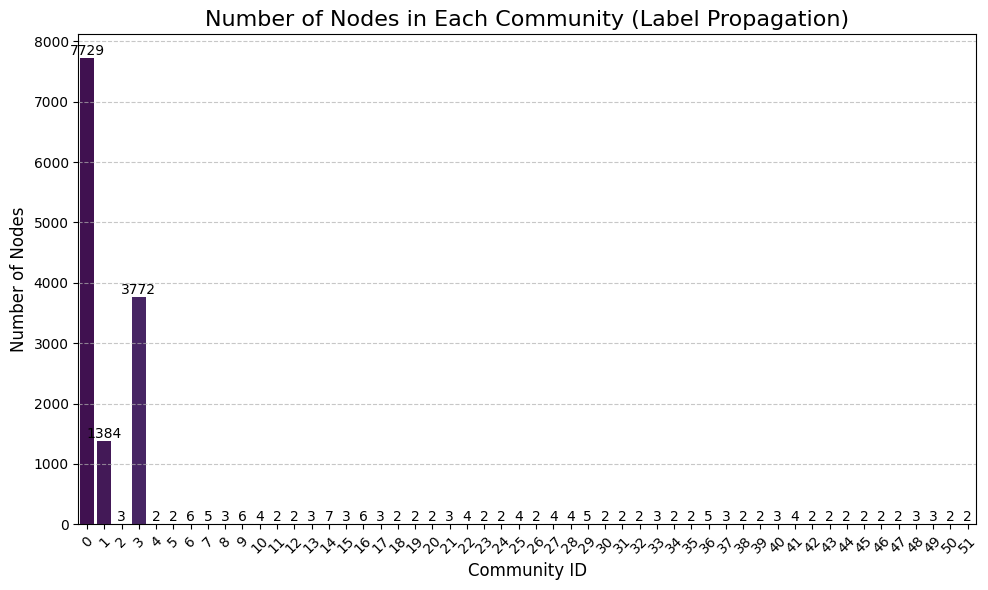

In [9]:
# Count the number of nodes in each community
community_sizes = lp_community_df["lp_community_id"].value_counts().sort_index()

# Plot a histogram of community sizes
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=community_sizes.index, y=community_sizes.values, palette="viridis")

# Add counts on top of each bar
for bar, count in zip(barplot.patches, community_sizes.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,  # Position the text
             str(count), ha='center', va='bottom', fontsize=10, color='black')

# Add titles and labels
plt.title("Number of Nodes in Each Community (Label Propagation)", fontsize=16)
plt.xlabel("Community ID", fontsize=12)
plt.ylabel("Number of Nodes", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()

plt.show()


In [10]:
lp_community_df

,node,lp_community_id
0,0,0
1,1,0
2,2,0
3,3,0
4,5,0
...,...,...
13027,12917,49
13028,12984,50
13029,12950,50
13030,12968,51


In [11]:
# Compute the count of nodes in each lp_community_id
community_counts = lp_community_df['lp_community_id'].value_counts()

# Define threshold (1% of total nodes)
threshold = int(0.01 * len(lp_community_df))  # 1% of 13032 = 131

# Filter communities that meet the threshold
interested_communities = community_counts[community_counts >= threshold].index

interested_communities

Index([0, 3, 1], dtype='int64', name='lp_community_id')

In [12]:
# Create filtered DataFrame
lp_communities_df = lp_community_df[lp_community_df['lp_community_id'].isin(interested_communities)]

# Print the number of communities retained
print(f"Number of communities after filtering: {lp_communities_df['lp_community_id'].nunique()}")
print(f"The communities are: {interested_communities}")

Number of communities after filtering: 3
The communities are: Index([0, 3, 1], dtype='int64', name='lp_community_id')


## Mapping the communities with the groups

In [13]:
lp_communities_df['groups'] = lp_communities_df['node'].apply(lambda x: G.nodes[x].get('groups', []))

lp_communities_df

/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_88254/1015274022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lp_communities_df['groups'] = lp_communities_df['node'].apply(lambda x: G.nodes[x].get('groups', []))


,node,lp_community_id,groups
0,0,0,"[58, 128]"
1,1,0,[]
2,2,0,[]
3,3,0,"[90, 131]"
4,5,0,[]
...,...,...,...
12883,8186,3,[]
12884,8187,3,[130]
12885,8188,3,[130]
12886,8190,3,[]


In [14]:
groups_df = pd.read_csv('/Users/prudhvivuda/Documents/SDFB_groups_2023_04_05.csv') 

# Create a dictionary mapping group ID to group name
entity_id_to_name = dict(zip(groups_df['id'], groups_df['name']))

# Function to map group IDs to group names
def map_group_names(entity_ids):
    return [entity_id_to_name.get(gid, "Unknown") for gid in entity_ids]

# Apply the mapping function to the 'groups' column
lp_communities_df['group_name'] = lp_communities_df['groups'].apply(map_group_names)

lp_communities_df


/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_88254/4240759.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lp_communities_df['group_name'] = lp_communities_df['groups'].apply(map_group_names)


,node,lp_community_id,groups,group_name
0,0,0,"[58, 128]","[Puritans, Scholars]"
1,1,0,[],[]
2,2,0,[],[]
3,3,0,"[90, 131]","[English Diplomats, Diplomats]"
4,5,0,[],[]
...,...,...,...,...
12883,8186,3,[],[]
12884,8187,3,[130],[Actors]
12885,8188,3,[130],[Actors]
12886,8190,3,[],[]


## Collecting the Belief Data

In [15]:
# beliefs = pd.DataFrame()

# for sim in processor.sims.iterrows():
#     _ = processor.beliefs[sim[0]].copy()
#     _["sim"] = sim[0]
#     _["op"] = sim[1].op
#     _["reliability"] = sim[1].reliability
#     beliefs = pd.concat([beliefs, _])
    
# beliefs = beliefs.reset_index()

# beliefs.to_parquet("beliefs.parquet")  # Save results

beliefs = pd.read_parquet("beliefs.parquet")  # Load results instantly

In [16]:
beliefs

,iteration,node,beliefs,sim,op,reliability
0,0,0,0.700109,0,UnreliableNetworkBasicGullibleBinomialOp,0.75
1,0,1,0.170376,0,UnreliableNetworkBasicGullibleBinomialOp,0.75
2,0,2,0.102609,0,UnreliableNetworkBasicGullibleBinomialOp,0.75
3,0,3,0.036047,0,UnreliableNetworkBasicGullibleBinomialOp,0.75
4,0,4,0.356989,0,UnreliableNetworkBasicGullibleBinomialOp,0.75
...,...,...,...,...,...,...
197043835,25000,13027,0.999999,59,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75
197043836,25000,13028,1.000000,59,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75
197043837,25000,13029,0.999676,59,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75
197043838,25000,13030,0.118809,59,UnreliableNetworkBasicGullibleNegativeEpsOp,0.75


### Visualize One Simulation or Sims Aggregated by Operators

In [17]:
def visualize_beliefs(beliefs, lp_communities_df, sim_id=None, operator=None, community_id=None, statistic='mean'):
    """
    Visualizes beliefs for one simulation or aggregated by operator, for a community or whole graph.
    - sim_id: If provided, visualizes one simulation.
    - operator: If provided (and sim_id is None), aggregates by operator.
    - community_id: If provided, filters to that community; else, uses whole graph.
    - statistic: 'mean', 'median', 'p25', 'p75' for aggregation.
    """
    agg_func = {
        'mean': 'mean',
        'median': 'median',
        'p25': lambda x: np.percentile(x, 25),
        'p75': lambda x: np.percentile(x, 75)
    }[statistic]

    # Filter data
    if sim_id is not None:
        data = beliefs[beliefs['sim'] == sim_id].copy()
        title_prefix = f"Simulation {sim_id}"
    elif operator is not None:
        data = beliefs[beliefs['op'] == operator].copy()
        title_prefix = f"Operator {operator} (Aggregated)"
    else:
        raise ValueError("Must provide sim_id or operator")

    if community_id is not None:
        community_nodes = lp_communities_df[lp_communities_df['lp_community_id'] == community_id]['node']
        data = data[data['node'].isin(community_nodes)]
        title_suffix = f" - Community {community_id}"
    else:
        title_suffix = " - Whole Graph"

    # Compute stats
    if sim_id is not None:
        stats = data.groupby('iteration')['beliefs'].agg(agg_func).reset_index()
    else:  # Aggregated by operator
        sim_stats = []
        for sim in data['sim'].unique():
            sim_data = data[data['sim'] == sim]
            sim_stat = sim_data.groupby('iteration')['beliefs'].agg(agg_func)
            sim_stats.append(sim_stat)
        stats = pd.concat(sim_stats, axis=1).mean(axis=1).reset_index()
        stats.columns = ['iteration', 'beliefs']

    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=stats, x='iteration', y='beliefs', label=f"{statistic.capitalize()}")
    plt.title(f"{statistic.capitalize()} Credences: {title_prefix}{title_suffix}", fontsize=16)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Credence", fontsize=12)
    plt.legend(title="Statistic")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

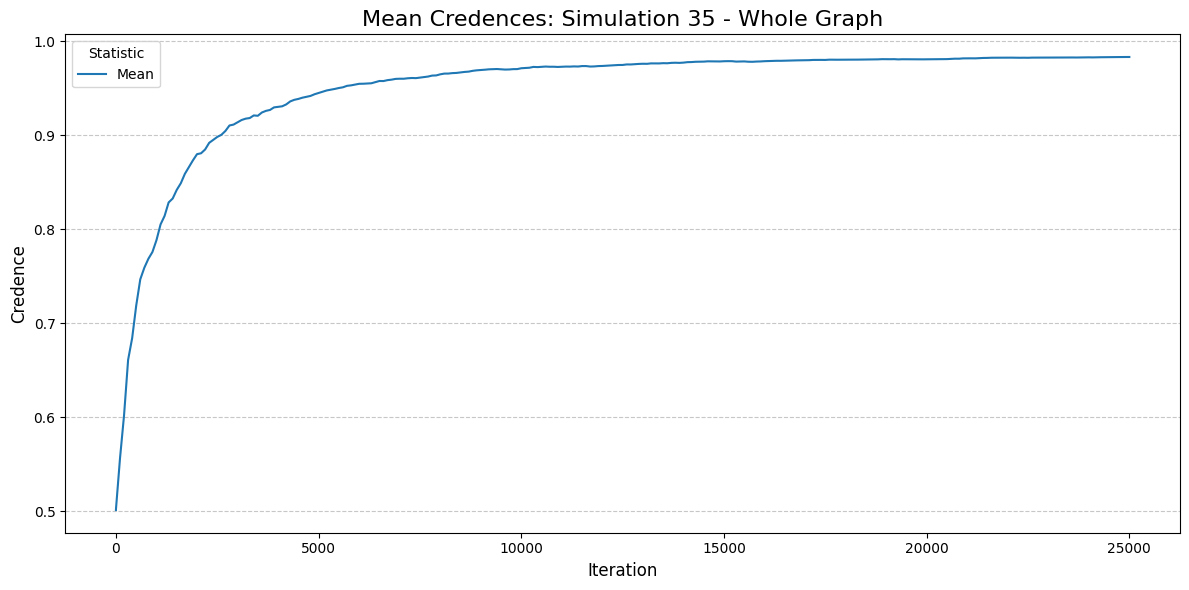

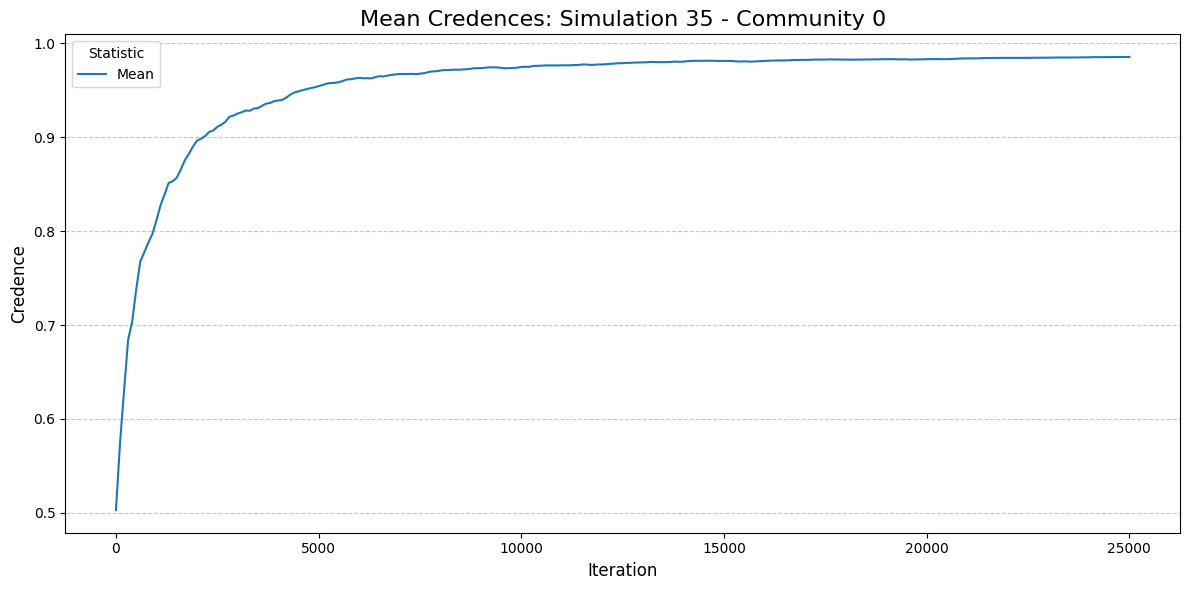

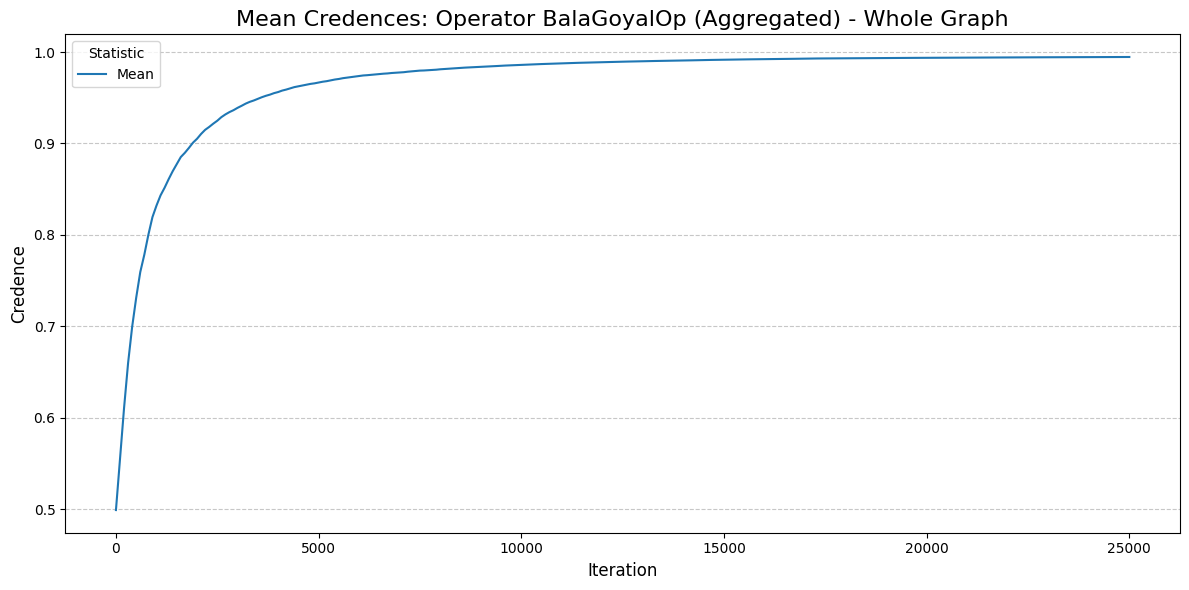

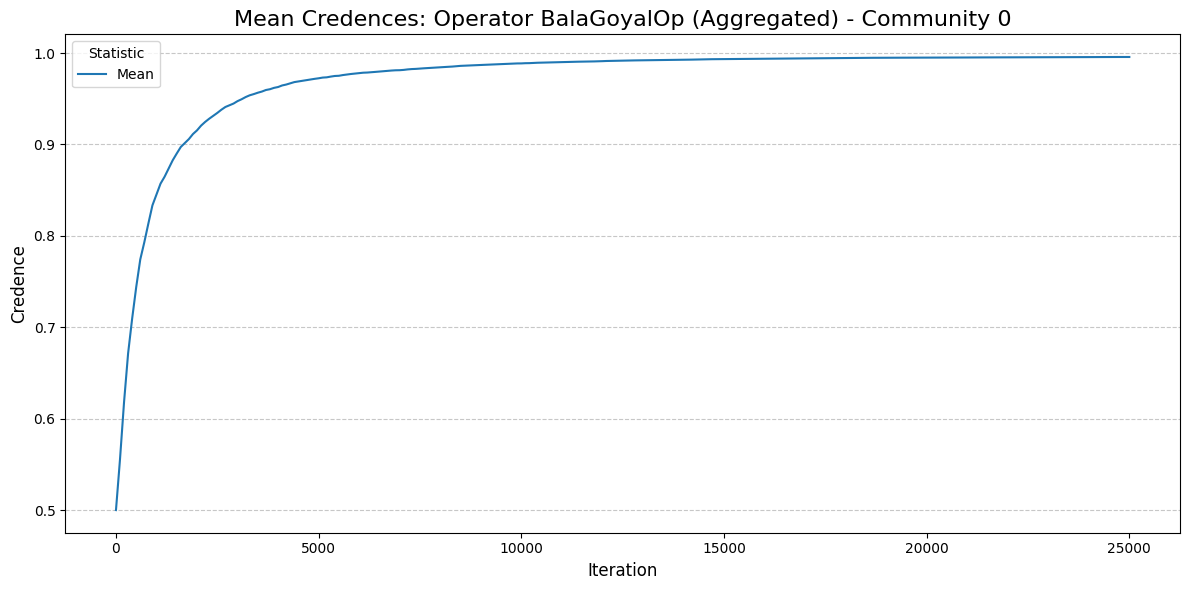

In [18]:
# one simulation, whole graph
visualize_beliefs(beliefs, lp_communities_df, sim_id=35)

# one simulation, community 0
visualize_beliefs(beliefs, lp_communities_df, sim_id=35, community_id=0)  

# aggregated by operator, whole graph
visualize_beliefs(beliefs, lp_communities_df, operator='BalaGoyalOp')     

# aggregated by operator, community 0
visualize_beliefs(beliefs, lp_communities_df, operator='BalaGoyalOp', community_id=0) 

### Descriptive and Structural stats

In [19]:
def plot_descriptive_stats(beliefs, lp_communities_df, sim_id=None, operator=None, community_id=None):
    """
    Plots descriptive stats (mean, median, p25, p75) for one sim or aggregated by op, community or whole graph.
    """
    if sim_id is not None:
        data = beliefs[beliefs['sim'] == sim_id].copy()
        title_prefix = f"Simulation {sim_id}"
    elif operator is not None:
        data = beliefs[beliefs['op'] == operator].copy()
        title_prefix = f"Operator {operator} (Aggregated)"
    else:
        raise ValueError("Must provide sim_id or operator")

    if community_id is not None:
        community_nodes = lp_communities_df[lp_communities_df['lp_community_id'] == community_id]['node']
        data = data[data['node'].isin(community_nodes)]
        title_suffix = f" - Community {community_id}"
    else:
        title_suffix = " - Whole Graph"

    # Compute descriptive stats
    if sim_id is not None:
        stats = data.groupby('iteration').agg(
            mean=('beliefs', 'mean'),
            median=('beliefs', 'median'),
            p25=('beliefs', lambda x: x.quantile(0.25)),
            p75=('beliefs', lambda x: x.quantile(0.75))
        ).reset_index()
    else:
        sim_stats = []
        for sim in data['sim'].unique():
            sim_data = data[data['sim'] == sim]
            sim_stat = sim_data.groupby('iteration').agg(
                mean=('beliefs', 'mean'),
                median=('beliefs', 'median'),
                p25=('beliefs', lambda x: x.quantile(0.25)),
                p75=('beliefs', lambda x: x.quantile(0.75))
            )
            sim_stats.append(sim_stat)
        stats = pd.concat(sim_stats).groupby('iteration').mean().reset_index()

    # Plot
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=stats, x='iteration', y='mean', label="Mean")
    sns.lineplot(data=stats, x='iteration', y='median', label="Median")
    sns.lineplot(data=stats, x='iteration', y='p25', label="25th Percentile")
    sns.lineplot(data=stats, x='iteration', y='p75', label="75th Percentile")
    plt.title(f"Descriptive Stats: {title_prefix}{title_suffix}", fontsize=16)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Credence", fontsize=12)
    plt.legend(title="Statistic")
    plt.grid(axis='y', linestyle='--', alpha=0.9)
    plt.tight_layout()
    plt.show()

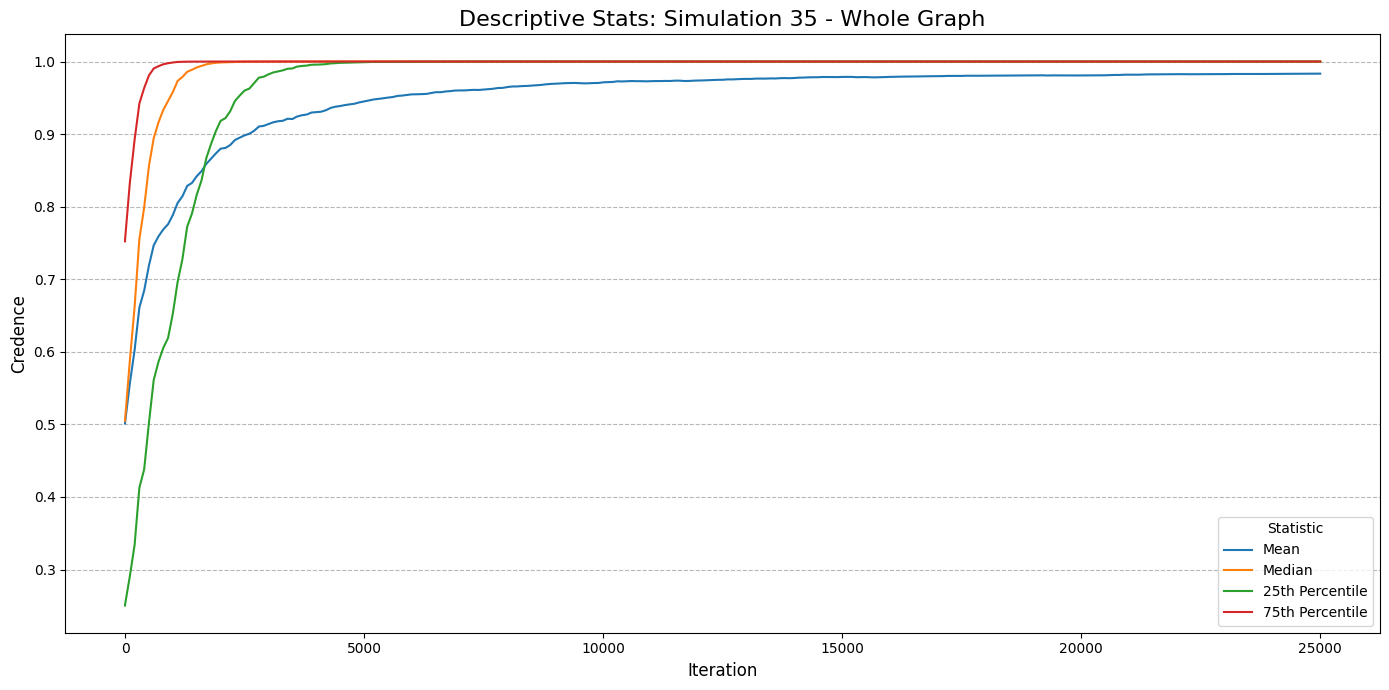

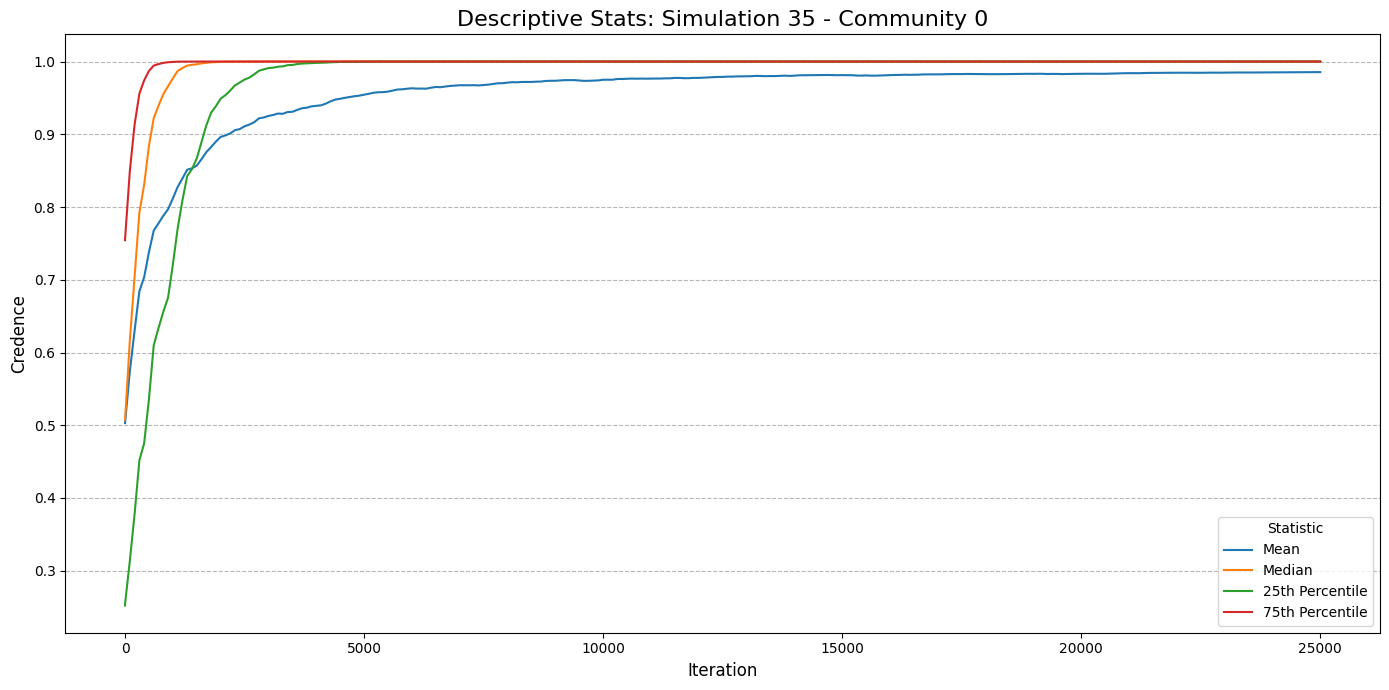

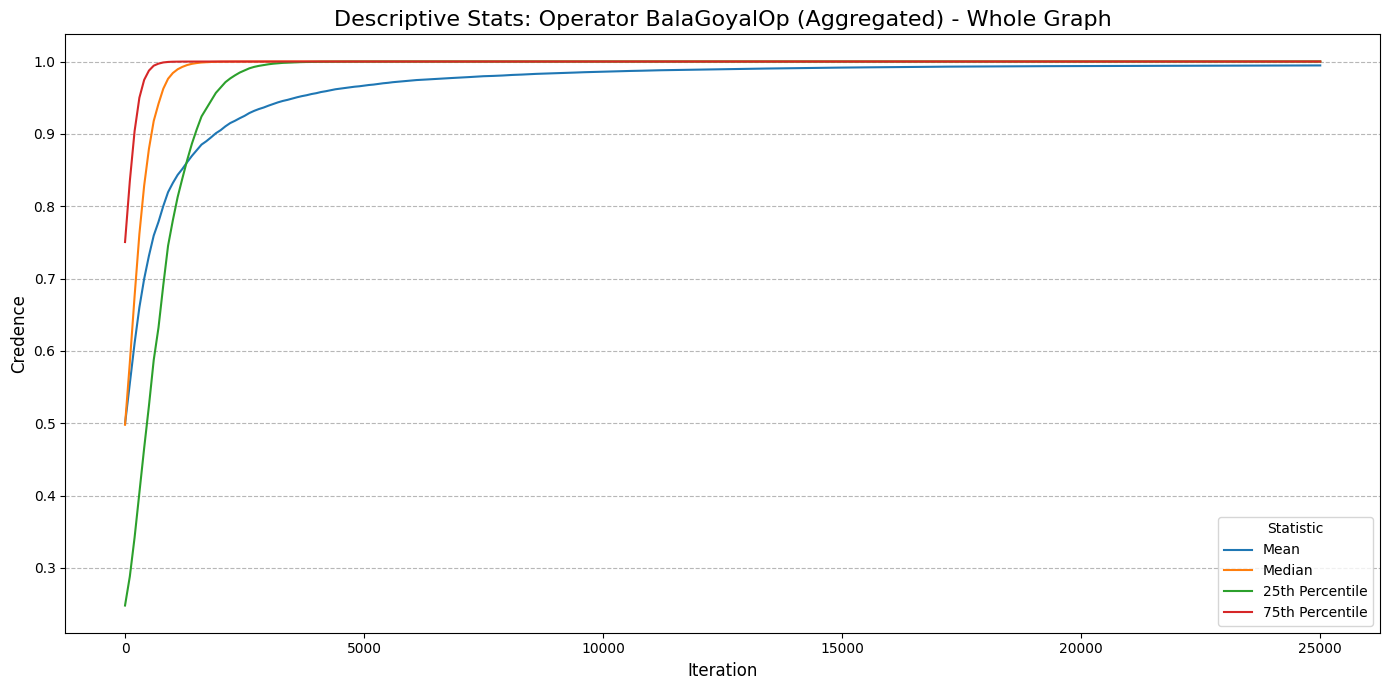

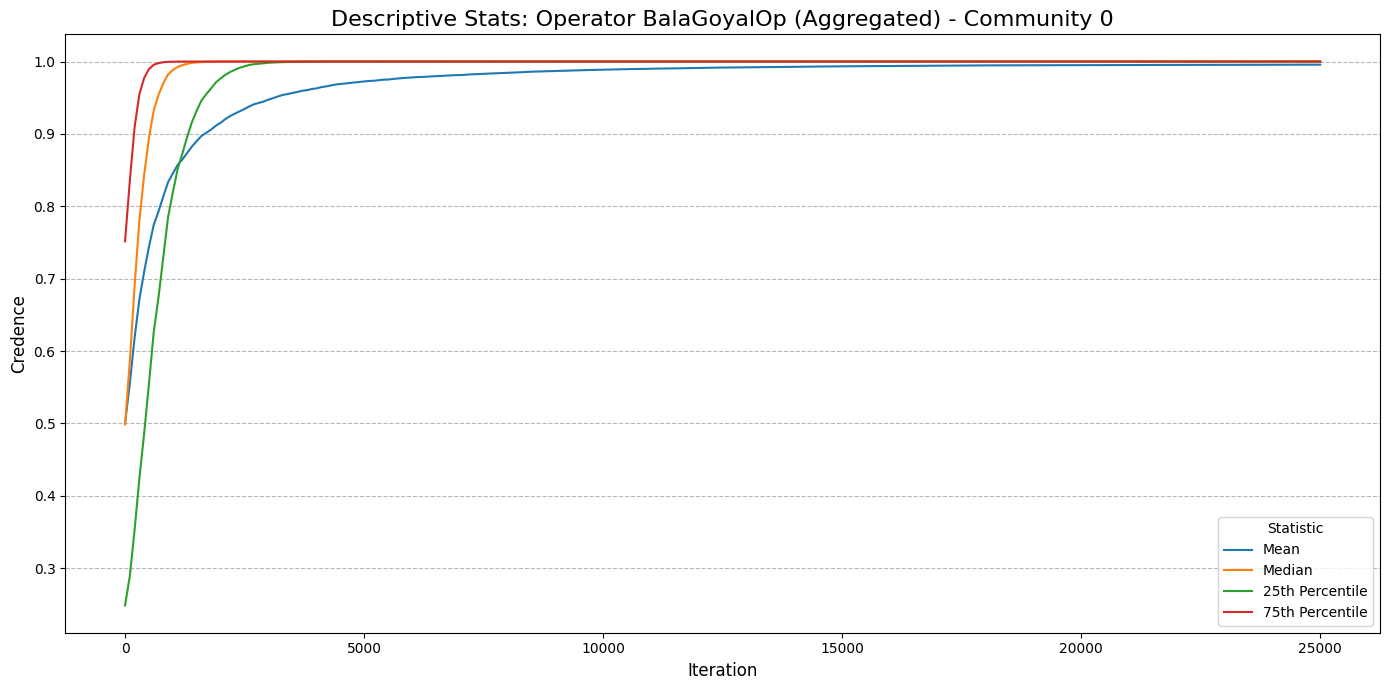

In [20]:
# one simulation, whole graph
plot_descriptive_stats(beliefs, lp_communities_df, sim_id=35)

# one simulation, community 0
plot_descriptive_stats(beliefs, lp_communities_df, sim_id=35, community_id=0)  

# aggregated by operator, whole graph
plot_descriptive_stats(beliefs, lp_communities_df, operator='BalaGoyalOp')     

# aggregated by operator, community 0
plot_descriptive_stats(beliefs, lp_communities_df, operator='BalaGoyalOp', community_id=0) 

In [21]:
def plot_general_structural_stats(beliefs, lp_communities_df, sim_id=None, operator=None, statistic='mean', community_ids=None, group_id=None):
    """
    Plots a chosen statistic for all nodes, community statistics, optional communities, and group.
    """
    agg_func = {
        'mean': 'mean',
        'median': 'median',
        'p25': lambda x: np.percentile(x, 25),
        'p75': lambda x: np.percentile(x, 75)
    }[statistic]

    if sim_id is not None:
        data = beliefs[beliefs['sim'] == sim_id].copy()
        title_prefix = f"Simulation {sim_id}"
    elif operator is not None:
        data = beliefs[beliefs['op'] == operator].copy()
        title_prefix = f"Operator {operator} (Aggregated)"
    else:
        raise ValueError("Must provide sim_id or operator")

    plt.figure(figsize=(14, 7))

    # Statistic of all nodes
    if sim_id is not None:
        overall_stat = data.groupby('iteration')['beliefs'].agg(agg_func)
    else:
        overall_stat = pd.concat([data[data['sim'] == s].groupby('iteration')['beliefs'].agg(agg_func) for s in data['sim'].unique()], axis=1).mean(axis=1)
    sns.lineplot(x=overall_stat.index, y=overall_stat.values, label=f"{statistic.capitalize()} (All Nodes)", color='black', linewidth=2)

    # Statistic of community statistics
    community_stats = []
    for cid in lp_communities_df['lp_community_id'].unique():
        nodes = lp_communities_df[lp_communities_df['lp_community_id'] == cid]['node']
        comm_data = data[data['node'].isin(nodes)]
        if sim_id is not None:
            comm_stat = comm_data.groupby('iteration')['beliefs'].agg(agg_func)
        else:
            comm_stat = pd.concat([comm_data[comm_data['sim'] == s].groupby('iteration')['beliefs'].agg(agg_func) for s in comm_data['sim'].unique()], axis=1).mean(axis=1)
        community_stats.append(comm_stat)
    stat_of_comm_stats = pd.concat(community_stats, axis=1).agg(agg_func, axis=1)
    sns.lineplot(x=stat_of_comm_stats.index, y=stat_of_comm_stats.values, label=f"{statistic.capitalize()} of Community {statistic.capitalize()}s", color='blue', linestyle=':')

    # Specific communities (with min/max)
    if community_ids:
        for cid in community_ids:
            nodes = lp_communities_df[lp_communities_df['lp_community_id'] == cid]['node']
            comm_data = data[data['node'].isin(nodes)]
            if sim_id is not None:
                comm_stat = comm_data.groupby('iteration')['beliefs'].agg([agg_func, 'min', 'max'])
            else:
                comm_stat = pd.concat([comm_data[comm_data['sim'] == s].groupby('iteration')['beliefs'].agg([agg_func, 'min', 'max']) for s in comm_data['sim'].unique()]).groupby('iteration').mean()
            sns.lineplot(x=comm_stat.index, y=comm_stat[statistic], label=f"Community {cid} {statistic.capitalize()}", )
            sns.lineplot(x=comm_stat.index, y=comm_stat['min'], label=f"Community {cid} Min", linestyle='--')
            sns.lineplot(x=comm_stat.index, y=comm_stat['max'], label=f"Community {cid} Max", linestyle='--')

    # Specific group
    if group_id is not None:
        group_nodes = lp_communities_df[lp_communities_df['groups'].apply(lambda x: group_id in x)]['node']
        group_data = data[data['node'].isin(group_nodes)]
        if sim_id is not None:
            group_stat = group_data.groupby('iteration')['beliefs'].agg([agg_func, 'min', 'max'])
        else:
            group_stat = pd.concat([group_data[group_data['sim'] == s].groupby('iteration')['beliefs'].agg([agg_func, 'min', 'max']) for s in group_data['sim'].unique()]).groupby('iteration').mean()
        group_name = entity_id_to_name.get(group_id, "Unknown")
        sns.lineplot(x=group_stat.index, y=group_stat[statistic], label=f"{group_name} {statistic.capitalize()}", )
        sns.lineplot(x=group_stat.index, y=group_stat['min'], label=f"{group_name} Min", linestyle='--')
        sns.lineplot(x=group_stat.index, y=group_stat['max'], label=f"{group_name} Max", linestyle='--')

    plt.title(f"{statistic.capitalize()} Structural Stats: {title_prefix} - Whole Graph", fontsize=16)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Credence", fontsize=12)
    plt.legend(title="Statistic")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

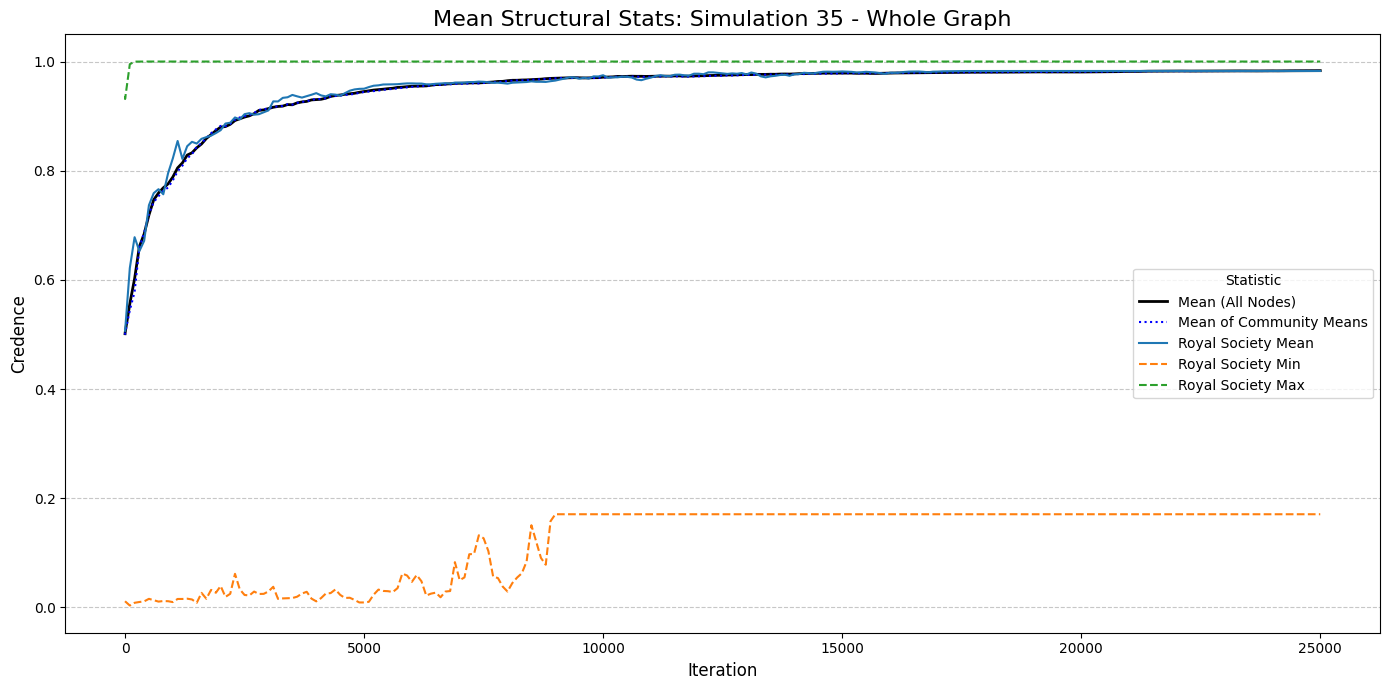

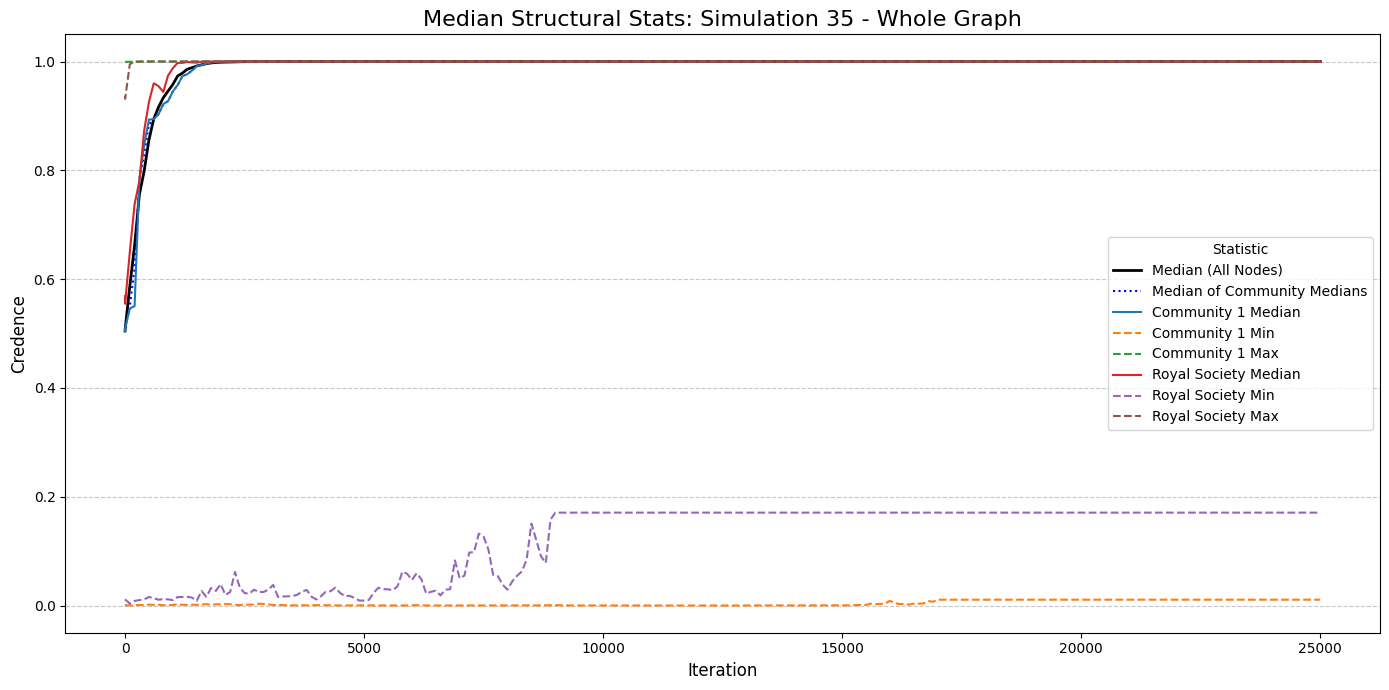

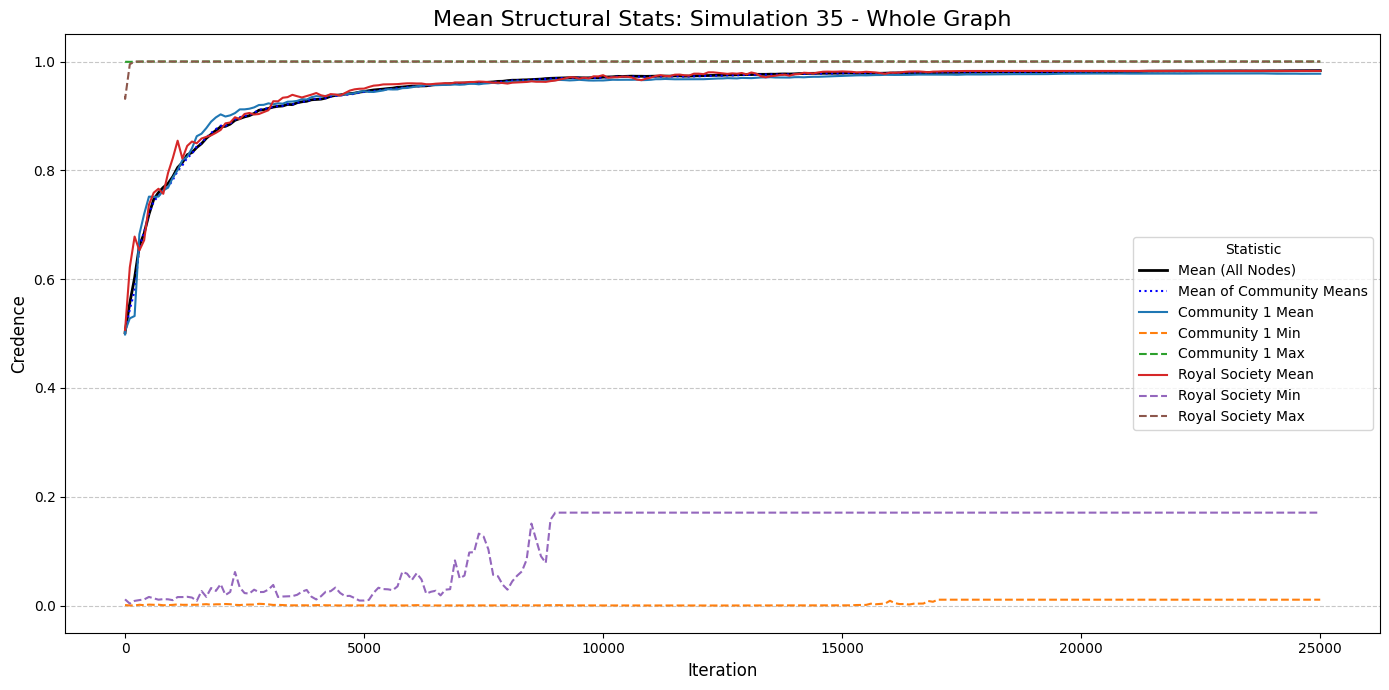

In [25]:
plot_general_structural_stats(beliefs, lp_communities_df, sim_id=35, statistic='mean', group_id=65)

plot_general_structural_stats(beliefs, lp_communities_df, sim_id=35, statistic='median', community_ids=[1], group_id=65)

plot_general_structural_stats(beliefs, lp_communities_df, sim_id=35, statistic='mean', community_ids=[1], group_id=65)

### Community credences

In [23]:
def visualize_belief_dynamics(beliefs, lp_communities_df, sim_id=None, operator=None, 
                             statistic='mean', agg_across_sims='mean', 
                             xlim=(0, 25000)):
    """
    Visualizes belief dynamics over iterations for communities and the whole graph.
    
    Parameters:
    - beliefs (pd.DataFrame): DataFrame with 'sim', 'op', 'node', 'iteration', 'beliefs' columns.
    - lp_communities_df (pd.DataFrame): DataFrame with 'node', 'lp_community_id' columns.
    - sim_id (int, optional): If provided, visualizes a single simulation.
    - operator (str, optional): If provided (and sim_id is None), aggregates across simulations for this operator.
    - statistic (str): Statistic for within-simulation aggregation ('mean', 'median', 'p25', 'p75').
    - agg_across_sims (str): Statistic for across-simulation aggregation ('mean', 'median', 'p25', 'p75').
      Ignored if sim_id is provided.
    - xlim (tuple): X-axis limits (default: (0, 25000)).
    
    Raises:
    - ValueError: If neither sim_id nor operator is provided.
    """
    # Define aggregation functions (string-based for Pandas compatibility)
    agg_func = {
        'mean': 'mean',
        'median': 'median',
        'p25': lambda x: x.quantile(0.25),
        'p75': lambda x: x.quantile(0.75)
    }[statistic]
    
    agg_across_func = {
        'mean': 'mean',
        'median': 'median',
        'p25': lambda x: x.quantile(0.25),
        'p75': lambda x: x.quantile(0.75)
    }[agg_across_sims] if operator is not None else None

    # Filter data based on sim_id or operator
    if sim_id is not None:
        data = beliefs[beliefs['sim'] == sim_id].copy()
        title_prefix = f"Simulation {sim_id}"
    elif operator is not None:
        data = beliefs[beliefs['op'] == operator].copy()
        title_prefix = f"Operator {operator} (Aggregated)"
    else:
        raise ValueError("Must provide either sim_id or operator")

    # Initialize storage for stats
    community_stats = {}
    graph_stats = {}

    if sim_id is not None:
        # Single simulation: compute stats directly
        for cid in lp_communities_df['lp_community_id'].unique():
            nodes = lp_communities_df[lp_communities_df['lp_community_id'] == cid]['node']
            comm_data = data[data['node'].isin(nodes)]
            if not comm_data.empty:
                community_stats[cid] = comm_data.groupby('iteration')['beliefs'].agg(agg_func)
        graph_stats = data.groupby('iteration')['beliefs'].agg(agg_func)
    else:
        # Aggregated across simulations
        for cid in lp_communities_df['lp_community_id'].unique():
            nodes = lp_communities_df[lp_communities_df['lp_community_id'] == cid]['node']
            comm_data = data[data['node'].isin(nodes)]
            if not comm_data.empty:
                sim_stats = [comm_data[comm_data['sim'] == s].groupby('iteration')['beliefs'].agg(agg_func) 
                             for s in comm_data['sim'].unique() if not comm_data[comm_data['sim'] == s].empty]
                if sim_stats:
                    community_stats[cid] = pd.concat(sim_stats, axis=1).agg(agg_across_func, axis=1)
        sim_stats = [data[data['sim'] == s].groupby('iteration')['beliefs'].agg(agg_func) 
                     for s in data['sim'].unique() if not data[data['sim'] == s].empty]
        graph_stats = pd.concat(sim_stats, axis=1).agg(agg_across_func, axis=1)

    # Plot
    plt.figure(figsize=(12, 6))
    for cid, stats in community_stats.items():
        sns.lineplot(x=stats.index, y=stats.values, label=f"Community {cid}")
    sns.lineplot(x=graph_stats.index, y=graph_stats.values, color='black', linestyle='--', 
                 label=f"Graph-wide {statistic.capitalize()}")

    # Customize plot
    plt.title(f"{statistic.capitalize()} Credences Over Iterations - {title_prefix}", fontsize=16)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Credence", fontsize=12)
    plt.xlim(xlim)
    plt.legend(title="Scope")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

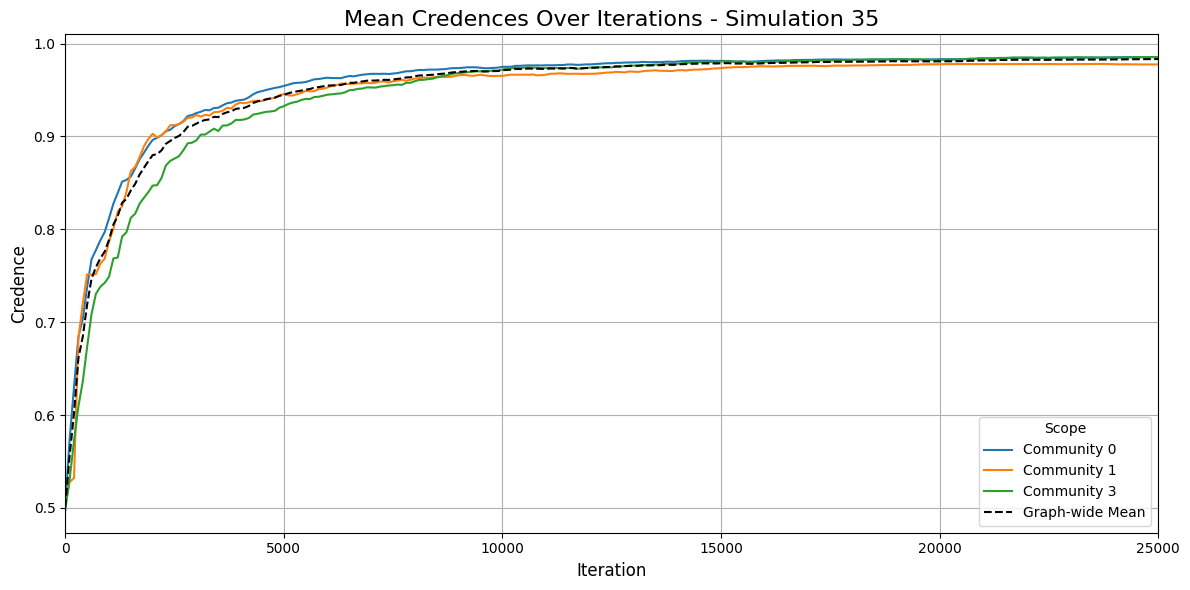

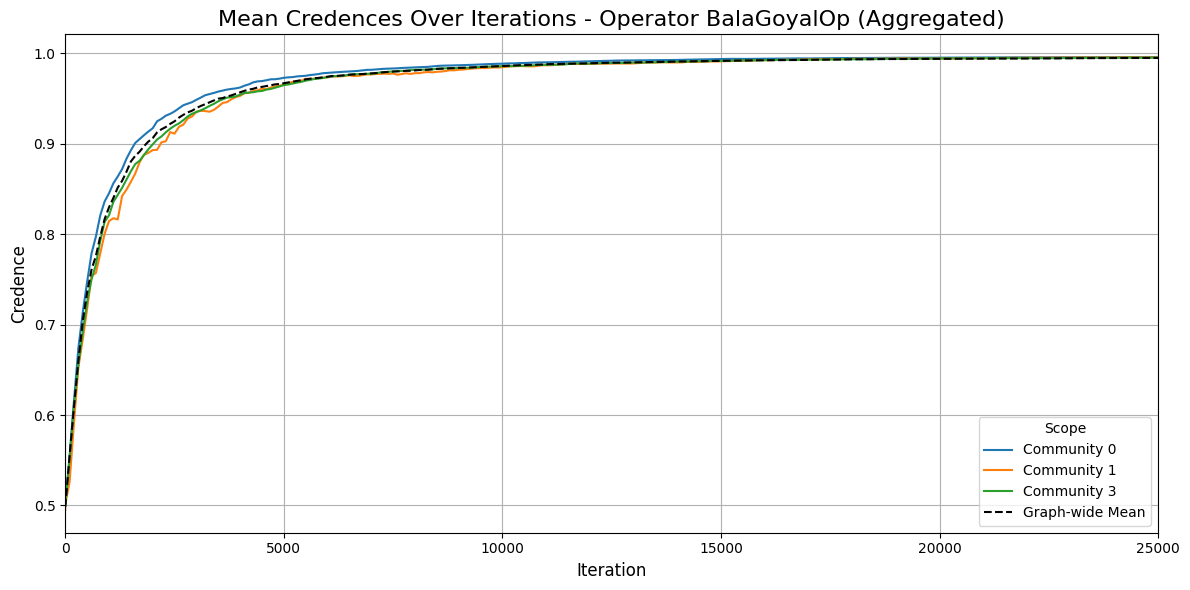

In [24]:
visualize_belief_dynamics(beliefs, lp_communities_df, sim_id=35, statistic='mean')

visualize_belief_dynamics(beliefs, lp_communities_df, operator='BalaGoyalOp', statistic='mean', agg_across_sims='median')